# 07.3e: Kissing Cluster Identification

**Goal:** Identify tokens that are at lattice-scale proximity ("kissing") and separate them from stragglers.

Starting from a 3D spherical slice, this notebook:
1. Identifies all tokens in the specified region
2. Computes pairwise L∞ distances (max component-wise separation)
3. Defines **kissing** as L∞ ≤ 2× bfloat16 ULP
4. Builds adjacency graph of kissing relationships
5. Filters to tokens with degree ≥ 1 (at least one kissing neighbor)
6. Saves kissing cluster token IDs for future analysis

**Output:** `kissing_cluster_lat23_lon164.safetensors` with token IDs of the true lattice-scale dense cluster.

## Parameters

In [1]:
# ============================================================================
# DATA FILES
# ============================================================================

TENSOR_DIR = "../data/tensors"

# Gamma vectors (promoted from bfloat16 to float32)
GAMMA_FILE = "gamma_qwen3_4b_instruct_2507.safetensors"
GAMMA_KEY = "gamma"

# Basis vectors (defines coordinate system)
BASIS_FILE = "pca_basis_vectors.safetensors"
BASIS_KEYS = {
    'north': '1',      # +Z: north (out of equatorial plane)
    'meridian': '2',   # +X: prime meridian (0° lon)
    'equinox': '3'     # +Y: equinox (90° lon)
}

# Viewpoint (for centering)
VIEWPOINT_FILE = "gamma_centroid_mu.safetensors"
VIEWPOINT_KEY = "mu"

# Black hole mask (optional)
MASK_FILE = "black_hole_mask.safetensors"
MASK_KEY = "mask"

# ============================================================================
# REGION OF INTEREST (Spherical coordinates)
# ============================================================================

# Latitude range (degrees, -90 to +90)
LAT_MIN = 23.0
LAT_MAX = 24.0

# Longitude range (degrees, -180 to +180)
LON_MIN = 164.0
LON_MAX = 165.0

# Radius range (Euclidean distance from viewpoint)
R_MIN = 0.1222
R_MAX = 0.1224

# ============================================================================
# KISSING THRESHOLD
# ============================================================================

# Two tokens "kiss" if their L∞ distance ≤ KISSING_ULP_THRESHOLD × ULP
KISSING_ULP_THRESHOLD = 2.0

# ============================================================================
# OUTPUT
# ============================================================================

OUTPUT_FILE = "kissing_cluster_lat23_lon164.safetensors"
OUTPUT_KEY = "token_ids"

## Imports

In [2]:
import torch
import numpy as np
from safetensors.torch import load_file, save_file
from pathlib import Path
import matplotlib.pyplot as plt

print("Imports loaded successfully.")

Imports loaded successfully.


## Step 1: Load Data

In [3]:
data_dir = Path(TENSOR_DIR)

print("Loading gamma matrix...")
gamma_data = load_file(data_dir / GAMMA_FILE)
gamma = gamma_data[GAMMA_KEY]
N, d = gamma.shape
print(f"  Shape: ({N:,}, {d:,})")
print(f"  Dtype: {gamma.dtype}")
print()

Loading gamma matrix...
  Shape: (151,936, 2,560)
  Dtype: torch.float32



In [4]:
print("Loading basis vectors...")
basis_data = load_file(data_dir / BASIS_FILE)
north_vector = basis_data[BASIS_KEYS['north']]
meridian_vector = basis_data[BASIS_KEYS['meridian']]
equinox_vector = basis_data[BASIS_KEYS['equinox']]
print(f"  North (+Z): {north_vector.shape}")
print(f"  Meridian (+X): {meridian_vector.shape}")
print(f"  Equinox (+Y): {equinox_vector.shape}")
print()

Loading basis vectors...
  North (+Z): torch.Size([2560])
  Meridian (+X): torch.Size([2560])
  Equinox (+Y): torch.Size([2560])



In [5]:
print("Loading viewpoint...")
viewpoint_data = load_file(data_dir / VIEWPOINT_FILE)
viewpoint = viewpoint_data[VIEWPOINT_KEY]
print(f"  Shape: {viewpoint.shape}")
print(f"  Norm: {torch.norm(viewpoint).item():.6f}")
print()

Loading viewpoint...
  Shape: torch.Size([2560])
  Norm: 0.304777



In [6]:
print("Loading mask...")
mask_data = load_file(data_dir / MASK_FILE)
mask = mask_data[MASK_KEY]
n_masked = mask.sum().item()
print(f"  Shape: {mask.shape}")
print(f"  Tokens to exclude: {n_masked:,} ({n_masked/N*100:.2f}%)")
print()

Loading mask...
  Shape: torch.Size([151936])
  Tokens to exclude: 2,100 (1.38%)



## Step 2: Compute Spherical Coordinates

In [7]:
print("Computing spherical coordinates...\n")

# Center at viewpoint
gamma_centered = gamma - viewpoint

# Project onto basis vectors
x = gamma_centered @ meridian_vector  # +X (prime meridian)
y = gamma_centered @ equinox_vector   # +Y (equinox)
z = gamma_centered @ north_vector     # +Z (north)

# Compute radius (full 3D distance)
r = torch.sqrt(x**2 + y**2 + z**2)

# Compute longitude (φ)
lon_rad = torch.atan2(y, x)
lon_deg = torch.rad2deg(lon_rad)

# Compute latitude (θ) using arcsin of normalized z
lat_rad = torch.asin(torch.clamp(z / (r + 1e-10), -1, 1))
lat_deg = torch.rad2deg(lat_rad)

print("✓ Spherical coordinates computed.")
print()

Computing spherical coordinates...

✓ Spherical coordinates computed.



## Step 3: Identify Candidate Tokens in Region

In [8]:
print(f"Identifying candidate tokens in region...\n")

# Create filter
region_filter = (
    ~mask &  # Exclude black holes
    (lat_deg >= LAT_MIN) & (lat_deg <= LAT_MAX) &
    (lon_deg >= LON_MIN) & (lon_deg <= LON_MAX) &
    (r >= R_MIN) & (r <= R_MAX)
)

# Get candidate token IDs
candidate_ids = torch.where(region_filter)[0]
n_candidates = len(candidate_ids)

print(f"Region: lat [{LAT_MIN}°, {LAT_MAX}°], lon [{LON_MIN}°, {LON_MAX}°], r [{R_MIN:.4f}, {R_MAX:.4f}]")
print(f"Candidate tokens found: {n_candidates:,}")
print()

if n_candidates == 0:
    print("⚠️  No tokens found in specified region. Adjust parameters and retry.")
    raise ValueError("No candidate tokens found")

print()

Identifying candidate tokens in region...

Region: lat [23.0°, 24.0°], lon [164.0°, 165.0°], r [0.1222, 0.1224]
Candidate tokens found: 113




## Step 4: Extract Vectors and Compute Pairwise L∞ Distances

In [9]:
# Extract gamma vectors for candidate tokens
vectors = gamma[candidate_ids]

print(f"Extracted {len(vectors):,} vectors for analysis.")
print(f"  Shape: {vectors.shape}")
print()

print("Computing pairwise L∞ distances...")

n = len(vectors)
n_pairs = n * (n - 1) // 2

print(f"  Number of pairs: {n_pairs:,}")

# Compute all pairwise differences
v1 = vectors.unsqueeze(1)  # [n, 1, d]
v2 = vectors.unsqueeze(0)  # [1, n, d]

# Component-wise absolute differences [n, n, d]
diffs = torch.abs(v1 - v2)

# L∞ distance (max component difference) [n, n]
l_inf_distances = diffs.max(dim=2)[0]

print(f"  ✓ Computed L∞ distance matrix: {l_inf_distances.shape}")
print()

Extracted 113 vectors for analysis.
  Shape: torch.Size([113, 2560])

Computing pairwise L∞ distances...
  Number of pairs: 6,328
  ✓ Computed L∞ distance matrix: torch.Size([113, 113])



## Step 5: Compute bfloat16 ULP Threshold

In [10]:
def bfloat16_ulp(x):
    """Compute bfloat16 ULP spacing for value x."""
    if x == 0:
        return 2.0 ** (-133)  # Minimum subnormal
    exponent = np.floor(np.log2(np.abs(x)))
    return 2.0 ** (exponent - 6)

# Analyze typical component magnitudes
component_abs = torch.abs(vectors)
typical_mag = component_abs.median().item()

# Compute ULP
ulp = bfloat16_ulp(typical_mag)
kissing_threshold = KISSING_ULP_THRESHOLD * ulp

print(f"Component magnitude statistics:")
print(f"  Median: {typical_mag:.6e}")
print()
print(f"bfloat16 ULP at median magnitude: {ulp:.6e}")
print(f"Kissing threshold ({KISSING_ULP_THRESHOLD}× ULP): {kissing_threshold:.6e}")
print()

Component magnitude statistics:
  Median: 3.585815e-03

bfloat16 ULP at median magnitude: 3.051758e-05
Kissing threshold (2.0× ULP): 6.103516e-05



## Step 6: Build Kissing Adjacency Graph

In [11]:
print("Building kissing adjacency graph...\n")

# Create adjacency matrix: 1 if kissing, 0 otherwise
# Don't count self-connections (diagonal = 0)
adjacency = (l_inf_distances <= kissing_threshold) & (l_inf_distances > 0)

# Count degree (number of kissing neighbors) for each token
degree = adjacency.sum(dim=1)

print(f"Kissing adjacency graph:")
print(f"  Total edges: {adjacency.sum().item() // 2:,} (undirected)")
print(f"  Tokens with ≥1 kissing neighbor: {(degree >= 1).sum().item():,}")
print(f"  Isolated tokens (no kissing neighbors): {(degree == 0).sum().item():,}")
print()

print(f"Degree distribution:")
print(f"  Min degree: {degree.min().item()}")
print(f"  Max degree: {degree.max().item()}")
print(f"  Mean degree: {degree.float().mean().item():.2f}")
print(f"  Median degree: {degree.float().median().item():.0f}")
print()

Building kissing adjacency graph...

Kissing adjacency graph:
  Total edges: 6,105 (undirected)
  Tokens with ≥1 kissing neighbor: 111
  Isolated tokens (no kissing neighbors): 2

Degree distribution:
  Min degree: 0
  Max degree: 110
  Mean degree: 108.05
  Median degree: 110



## Step 7: Filter to Kissing Cluster

In [12]:
print("Filtering to kissing cluster...\n")

# Keep only tokens with at least one kissing neighbor
kissing_mask = degree >= 1
kissing_indices = torch.where(kissing_mask)[0]

# Map back to original token IDs
kissing_token_ids = candidate_ids[kissing_indices]

n_kissing = len(kissing_token_ids)
n_rejected = n_candidates - n_kissing

print(f"Kissing cluster identified:")
print(f"  Candidate tokens: {n_candidates:,}")
print(f"  Kissing cluster size: {n_kissing:,}")
print(f"  Rejected (isolated): {n_rejected:,} ({n_rejected/n_candidates*100:.1f}%)")
print()

print(f"Kissing cluster token IDs (first 20):")
print(f"  {kissing_token_ids[:20].tolist()}")
if n_kissing > 20:
    print(f"  ... and {n_kissing - 20} more")
print()

Filtering to kissing cluster...

Kissing cluster identified:
  Candidate tokens: 113
  Kissing cluster size: 111
  Rejected (isolated): 2 (1.8%)

Kissing cluster token IDs (first 20):
  [123821, 123952, 124084, 124178, 124530, 124608, 124707, 124769, 124860, 125047, 125071, 125125, 125458, 125527, 125655, 125687, 125869, 126316, 126677, 126848]
  ... and 91 more



## Step 8: Analyze Kissing Cluster Connectivity

In [13]:
print("Analyzing kissing cluster connectivity...\n")

# Extract subgraph for kissing cluster
kissing_adjacency = adjacency[kissing_indices][:, kissing_indices]
kissing_degree = kissing_adjacency.sum(dim=1)

# Count edges in kissing cluster
n_edges = kissing_adjacency.sum().item() // 2

# Max possible edges in fully connected graph
max_edges = n_kissing * (n_kissing - 1) // 2

# Density of kissing graph
graph_density = n_edges / max_edges if max_edges > 0 else 0

print(f"Kissing cluster graph:")
print(f"  Nodes: {n_kissing:,}")
print(f"  Edges: {n_edges:,}")
print(f"  Max possible edges: {max_edges:,}")
print(f"  Graph density: {graph_density:.2%}")
print()

print(f"Degree distribution in kissing cluster:")
print(f"  Min: {kissing_degree.min().item()}")
print(f"  Max: {kissing_degree.max().item()}")
print(f"  Mean: {kissing_degree.float().mean().item():.2f}")
print(f"  Median: {kissing_degree.float().median().item():.0f}")
print()

Analyzing kissing cluster connectivity...

Kissing cluster graph:
  Nodes: 111
  Edges: 6,105
  Max possible edges: 6,105
  Graph density: 100.00%

Degree distribution in kissing cluster:
  Min: 110
  Max: 110
  Mean: 110.00
  Median: 110



## Step 9: Visualize Degree Distribution

Creating degree distribution histogram...



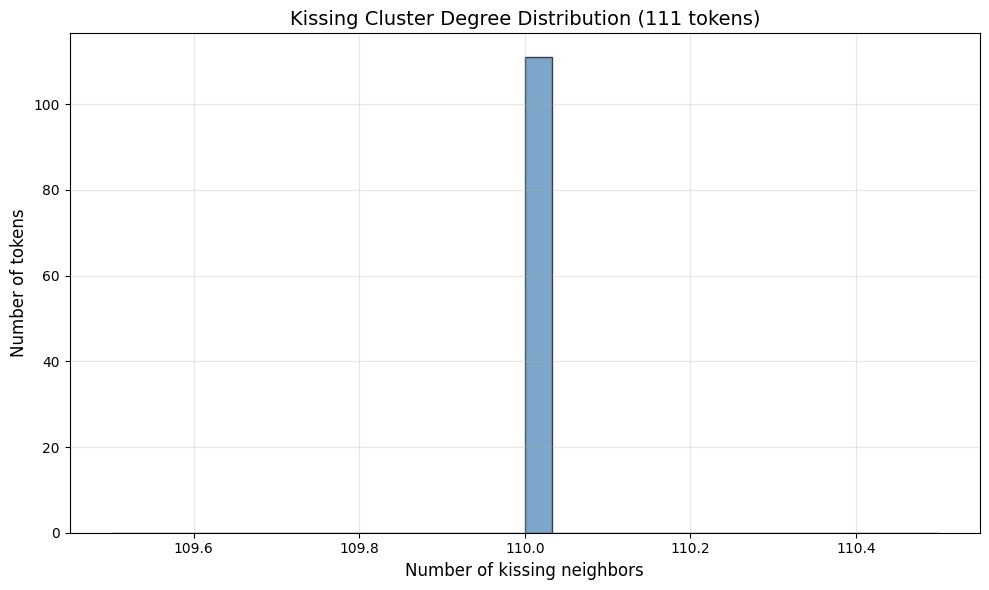

✓ Degree distribution plotted.



In [14]:
if n_kissing > 0:
    print("Creating degree distribution histogram...\n")
    
    fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
    
    degree_np = kissing_degree.cpu().numpy()
    
    ax.hist(degree_np, bins=min(30, degree_np.max() + 1), 
            color='steelblue', alpha=0.7, edgecolor='black')
    
    ax.set_xlabel('Number of kissing neighbors', fontsize=12)
    ax.set_ylabel('Number of tokens', fontsize=12)
    ax.set_title(f'Kissing Cluster Degree Distribution ({n_kissing:,} tokens)', 
                 fontsize=14)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Degree distribution plotted.")
    print()
else:
    print("⚠️  No kissing cluster found - skipping visualization.")
    print()

## Step 10: Save Kissing Cluster Token IDs

In [15]:
output_path = data_dir / OUTPUT_FILE

print(f"Saving kissing cluster token IDs to {output_path}...")

# Convert to int64 for consistency
kissing_token_ids_int64 = kissing_token_ids.long()

save_file({OUTPUT_KEY: kissing_token_ids_int64}, output_path)

print(f"✓ Saved {n_kissing:,} token IDs to {OUTPUT_FILE}")
print()
print(f"To use in other notebooks:")
print(f"  kissing_data = load_file('{OUTPUT_FILE}')")
print(f"  kissing_ids = kissing_data['{OUTPUT_KEY}']")
print()

Saving kissing cluster token IDs to ../data/tensors/kissing_cluster_lat23_lon164.safetensors...
✓ Saved 111 token IDs to kissing_cluster_lat23_lon164.safetensors

To use in other notebooks:
  kissing_data = load_file('kissing_cluster_lat23_lon164.safetensors')
  kissing_ids = kissing_data['token_ids']



## Summary

In [16]:
print("=" * 60)
print("KISSING CLUSTER SUMMARY")
print("=" * 60)
print()
print(f"Region: lat [{LAT_MIN}°, {LAT_MAX}°], lon [{LON_MIN}°, {LON_MAX}°], r [{R_MIN:.4f}, {R_MAX:.4f}]")
print()
print(f"Candidate tokens: {n_candidates:,}")
print(f"Kissing cluster: {n_kissing:,}")
print(f"Rejected: {n_rejected:,} ({n_rejected/n_candidates*100:.1f}%)")
print()
print(f"Kissing threshold: {KISSING_ULP_THRESHOLD}× ULP = {kissing_threshold:.6e}")
print(f"Typical component magnitude: {typical_mag:.6e}")
print()
print(f"Graph properties:")
print(f"  Nodes: {n_kissing:,}")
print(f"  Edges: {n_edges:,}")
print(f"  Density: {graph_density:.2%}")
print(f"  Mean degree: {kissing_degree.float().mean().item():.2f}")
print()
print(f"Output: {OUTPUT_FILE}")
print()
print("=" * 60)

KISSING CLUSTER SUMMARY

Region: lat [23.0°, 24.0°], lon [164.0°, 165.0°], r [0.1222, 0.1224]

Candidate tokens: 113
Kissing cluster: 111
Rejected: 2 (1.8%)

Kissing threshold: 2.0× ULP = 6.103516e-05
Typical component magnitude: 3.585815e-03

Graph properties:
  Nodes: 111
  Edges: 6,105
  Density: 100.00%
  Mean degree: 110.00

Output: kissing_cluster_lat23_lon164.safetensors

